In [22]:
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision.models import resnet152
import shutil
import os
import matplotlib.pyplot as plt
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.metrics import accuracy_score
import cv2
from tqdm.notebook import tqdm
import sys
import pandas as pd

In [23]:
SEED = 0

TRAIN_PATH = '../input/cleaned-vs-dirty-v2/plates/train'
TEST_PATH = '../input/cleaned-vs-dirty-v2/plates/test'
SLASH = '/'

N_OF_ADDITIONAL_IMGS_PER_CLASS = 200

RESIZING_SIZE = 300
CROP_SIZE = 224
MEAN = (0.485, 0.456, 0.406)
STD = (0.229, 0.224, 0.225)

BATCH_SIZE = 32

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
LR = 3e-4
EPOCHS = 5

In [24]:
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

In [25]:
train_imgs = []
train_labels = []
for folder in os.listdir(TRAIN_PATH):
    imgs_names = os.listdir(TRAIN_PATH + SLASH + folder)
    train_imgs_paths = [TRAIN_PATH + SLASH + folder + SLASH + name for name in imgs_names]
    train_imgs.extend(train_imgs_paths)
    if folder == 'cleaned':
        train_labels.extend([0 for i in range(len(imgs_names))])
    else:
        train_labels.extend([1 for i in range(len(imgs_names))])

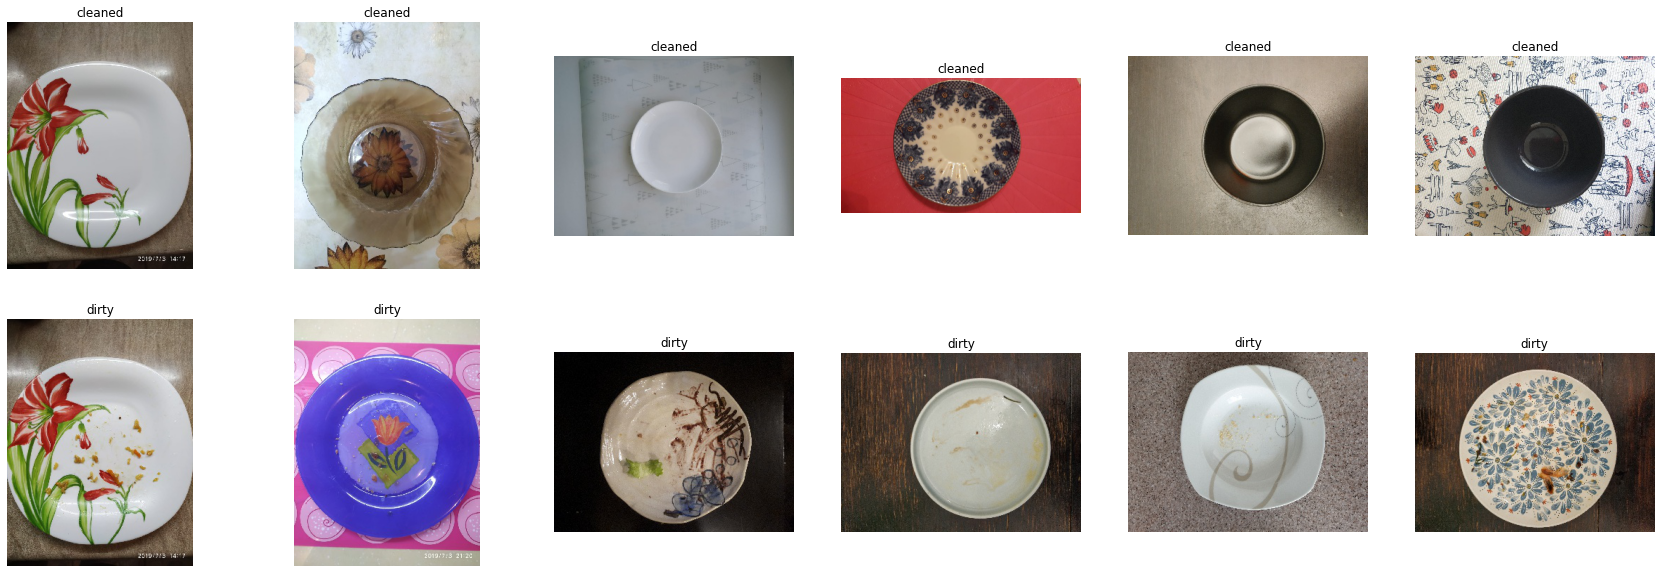

In [26]:
ncols = 6
fig, axes = plt.subplots(nrows=2, ncols=ncols, figsize=(30, 10))
index_for_clean = 0
index_for_dirty = np.argmax(train_labels)
for c in range(ncols):
    for r in range(1):
        axes[r, c].imshow(Image.open(train_imgs[index_for_clean]))
        axes[r, c].set_title('cleaned')
        axes[r, c].axis('off')
        axes[r+1, c].imshow(Image.open(train_imgs[index_for_dirty]))
        axes[r+1, c].set_title('dirty')
        axes[r+1, c].axis('off')
        index_for_clean += 1
        index_for_dirty += 1

In [27]:
for label in range(2):
    
    for i in range(N_OF_ADDITIONAL_IMGS_PER_CLASS):
        
        indices_for_label_image = np.where(np.array(train_labels) == label)[0]
        random_idx_of_label_image = np.random.choice(indices_for_label_image)
        rand_image = train_imgs[random_idx_of_label_image]
        train_imgs.append(rand_image)
        train_labels.append(label)

In [28]:
test_imgs_names = []
for image in os.listdir(TEST_PATH):
    test_imgs_names.append(image)
test_imgs_names = sorted(test_imgs_names)

test_imgs = []
for image in test_imgs_names:
    test_imgs.append(TEST_PATH + SLASH + image)

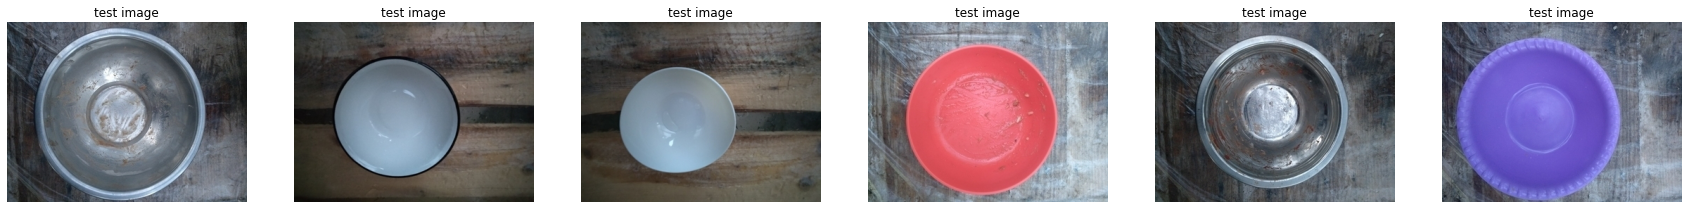

In [29]:
ncols = 6
fig, axes = plt.subplots(nrows=1, ncols=ncols, figsize=(30, 10))
for c in range(ncols):
    axes[c].imshow(Image.open(test_imgs[np.random.randint(low=0, high=len(test_imgs))]))
    axes[c].set_title('test image')
    axes[c].axis('off')

In [30]:
class PlatesDataset(Dataset):
    
    def __init__(self, images_paths, labels=None, transforms=None):
        self.images_paths = images_paths
        self.labels = labels
        self.transforms = transforms
    
    def __len__(self):
        return len(self.images_paths)
    
    def __getitem__(self, idx):
        image_path = self.images_paths[idx]
        image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
        
        # resizing and rescaling of image
        resize_rescale = A.Compose([
            A.geometric.resize.Resize(
                RESIZING_SIZE, RESIZING_SIZE
            ),
            A.crops.transforms.CenterCrop(
                CROP_SIZE, CROP_SIZE
            ),
        ])
        image_orig = resize_rescale(image=image)['image']
        
        # removing background as much as possible through grabCut of OpenCV
        mask = np.zeros(image_orig.shape[:2], np.uint8)
        bgdModel = np.zeros((1, 65), np.float64)
        fgdModel = np.zeros((1, 65), np.float64)
        rect = (1, 1, 224, 224) # values were picked through experimenting
        cv2.grabCut(image_orig, mask, rect, bgdModel, fgdModel, 5, cv2.GC_INIT_WITH_RECT)
        mask2 = np.where((mask == 2) | (mask == 0), 0, 1).astype('uint8')
        image = image_orig * mask2[:, :, np.newaxis]
        background = image_orig - image
        background[np.where((background > [0, 0, 0]).all(axis = 2))] = [255, 255, 255]
        image = background + image
        
        if self.transforms is not None:
            image = self.transforms(image=image)['image']
        
        if self.labels is not None:
            label = self.labels[idx]
            return image, label
        else:
            return image

In [31]:
train_transforms = A.Compose([
    A.augmentations.geometric.rotate.Rotate(
        limit=90,
        p=0.7,
    ),
    A.augmentations.transforms.ChannelShuffle(
        p=0.7
    ),
    A.augmentations.transforms.ColorJitter(
        brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, p=0.7
    ),
    A.augmentations.transforms.GaussNoise(
        p=0.7
    ),
    A.augmentations.transforms.Normalize(
        mean=MEAN, std=STD
    ),
    ToTensorV2()
])

test_transforms = A.Compose([
    A.augmentations.transforms.Normalize(
        mean=MEAN, std=STD
    ),
    ToTensorV2()
])

In [32]:
train_dataset = PlatesDataset(train_imgs, train_labels, transforms=train_transforms)
test_dataset = PlatesDataset(test_imgs, transforms=test_transforms)

In [33]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
        return tensor

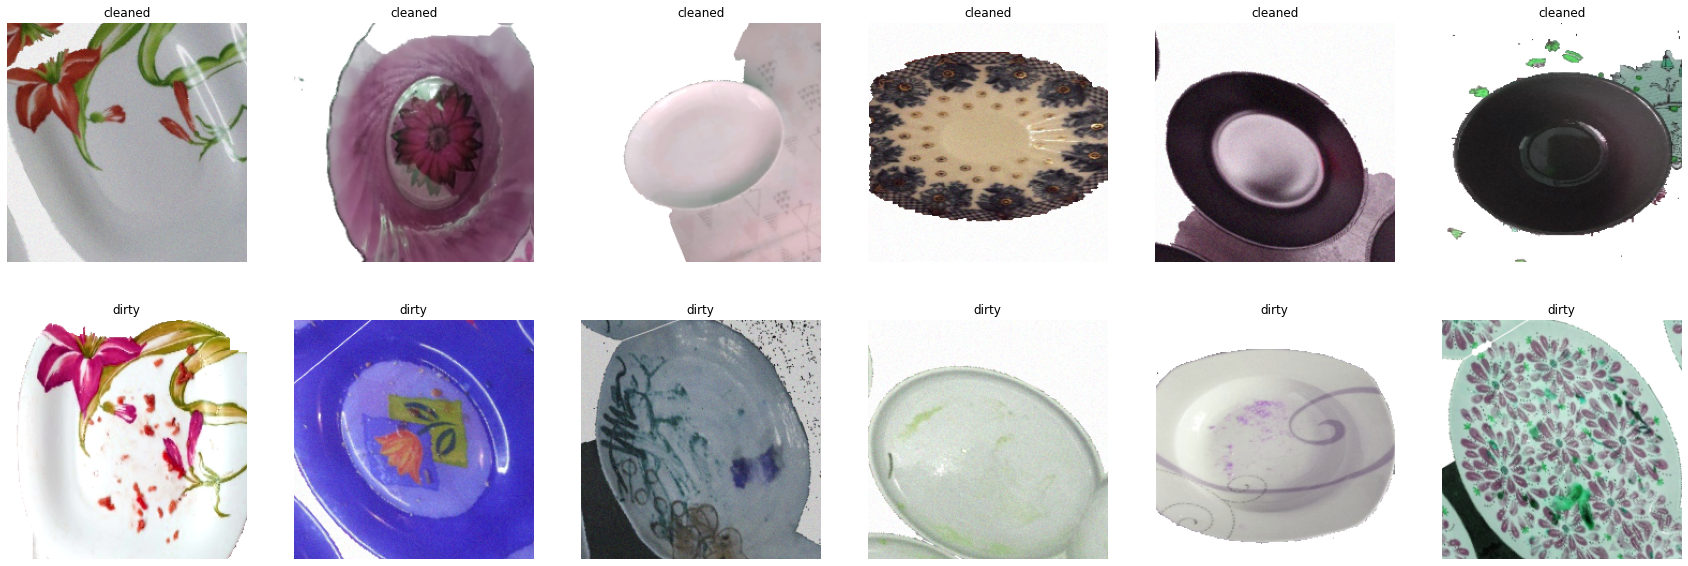

In [34]:
ncols = 6
fig, axes = plt.subplots(nrows=2, ncols=ncols, figsize=(30, 10))
index_for_clean = 0
index_for_dirty = np.argmax(train_labels)

unnormalization = UnNormalize(MEAN, STD)

for c in range(ncols):
    for r in range(1):
        axes[r, c].imshow(np.transpose(unnormalization(train_dataset[index_for_clean][0]).numpy(), (2, 1, 0)))
        axes[r, c].set_title('cleaned')
        axes[r, c].axis('off')
        axes[r+1, c].imshow(np.transpose(unnormalization(train_dataset[index_for_dirty][0]).numpy(), (2, 1, 0)))
        axes[r+1, c].set_title('dirty')
        axes[r+1, c].axis('off')
        index_for_clean += 1
        index_for_dirty += 1

In [35]:
model = resnet152(pretrained=True)

In [36]:
for index, model_part in enumerate(model.children()):
    if index < 7:
        for param in model_part.parameters():
            param.requires_grad = False
            
model.fc = torch.nn.Linear(2048, 2)

In [37]:
model = model.to(DEVICE)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), amsgrad=True, lr=LR)

In [38]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [39]:
for e in range(1, EPOCHS+1):
    model.train()
    
    train_loss_batch = 0
    train_predicted_total = []
    train_true_total = []
    with tqdm(total=len(train_dataloader), file=sys.stdout) as prbar:
        for images_batch, labels_batch in train_dataloader:
            
            optimizer.zero_grad()
            
            images_batch = images_batch.to(DEVICE)
            labels_batch = labels_batch.to(DEVICE)
            logits = model(images_batch)
            loss = criterion(logits, labels_batch)
            loss.backward()
            optimizer.step()
            
            train_loss_batch += loss.item()
            train_predicted_total.extend(logits.detach().cpu().argmax(1))
            train_true_total.extend(labels_batch.detach().cpu())
            accuracy_for_batch = accuracy_score(train_true_total, train_predicted_total)
            prbar.set_description(
                f'Train loss: {round(train_loss_batch / (index+1), 4)} '
                f'Train accuracy: {round(accuracy_for_batch, 4)}'
            )
            prbar.update(1)

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

In [40]:
test_labels = []
model.eval()

with tqdm(total=len(test_dataloader), file=sys.stdout) as prbar:
    with torch.no_grad():
        for images_batch in test_dataloader:

            images_batch = images_batch.to(DEVICE)
            logits = model(images_batch)
            test_labels.extend(logits.detach().cpu().argmax(1).numpy())

            prbar.update(1)

  0%|          | 0/24 [00:00<?, ?it/s]

In [41]:
test_imgs_final = []
for image in test_imgs_names:
    test_imgs_final.append(image.split('.')[0])

In [42]:
sub = pd.DataFrame({'id': test_imgs_final, 'label': test_labels})
sub['label'] = sub['label'].map(lambda pred: 'dirty' if pred == 1 else 'cleaned')
sub.to_csv('submission.csv', index=False)

In [43]:
from IPython.display import FileLink
FileLink(r'submission.csv')

/kaggle/working/submission.csv